Predicting the price of a house based on its features
- Dataset: California Housing (from sklearn.datasets)

Import datset

Each row in the dataset represents a small area (similar to a neighborhood or statistical block) in which census averages were calculated.

In [43]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# load the dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# check the first 5 rows
print(df.head())


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


Check the dataset

Problems / obs resulted:
1. Some columns have outliers (Rooms, Occup)
2. The population is very unevenly distributed.
3. MedHouseVal seems truncated at 5.0
4. Geographic data could be grouped

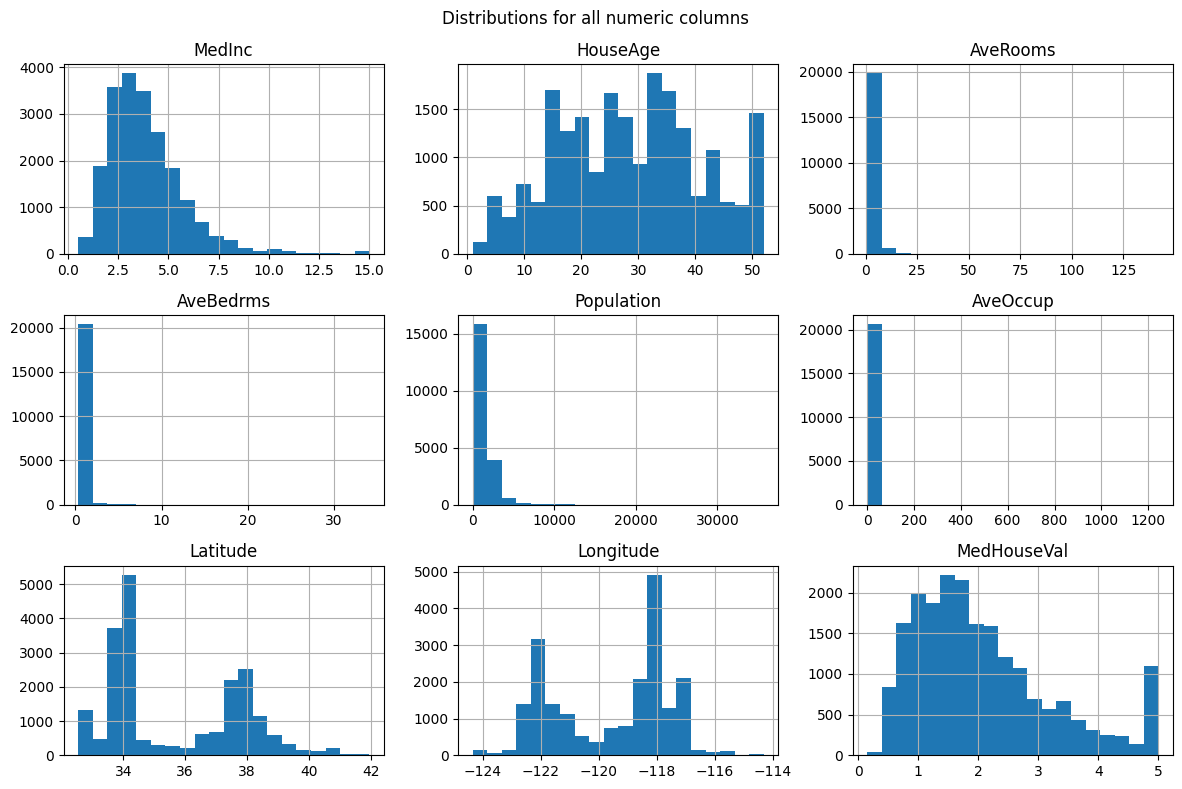

In [44]:
import matplotlib.pyplot as plt

df.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distributions for all numeric columns")
plt.tight_layout()
plt.show()


Eliminate data

Initial: 20640 rows
Without outliers: 18312 rows


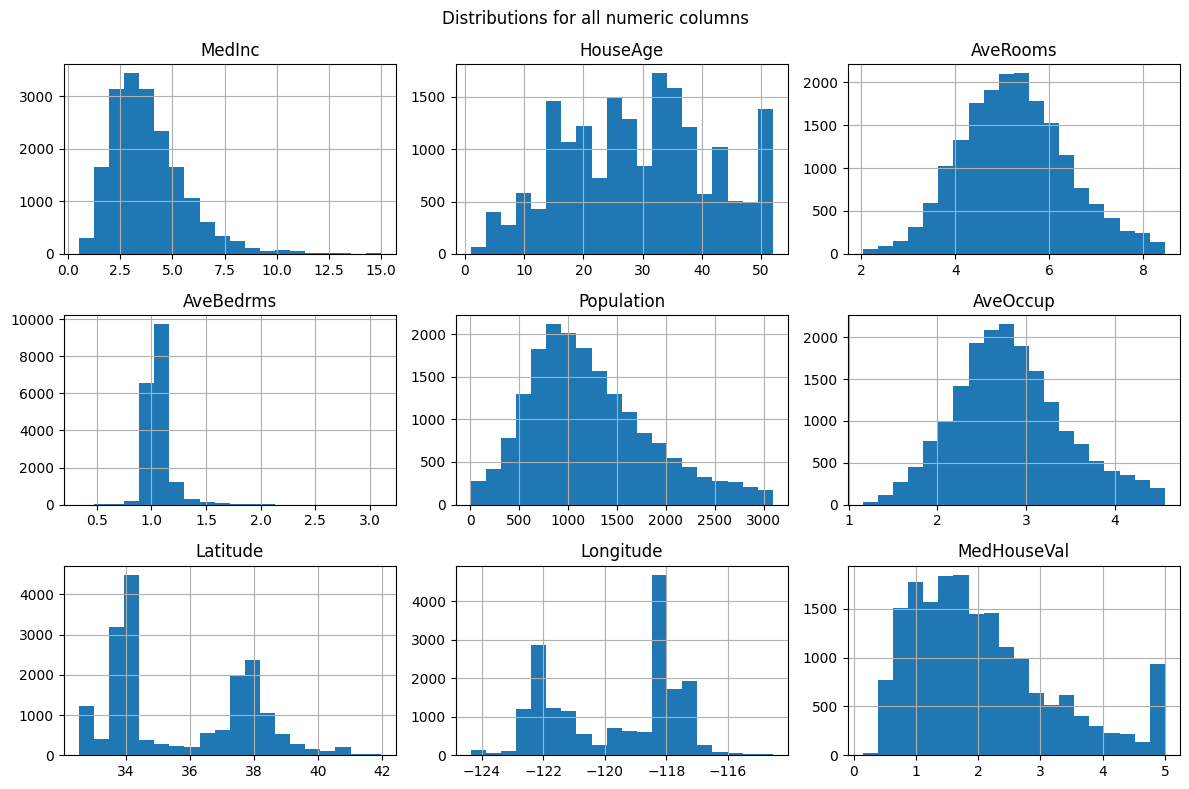

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

columns_to_check = ["AveRooms", "AveOccup", "Population", "HouseAge"]
df_cleaned = remove_outliers_iqr(df, columns_to_check)

print(f"Initial: {df.shape[0]} rows")
print(f"Without outliers: {df_cleaned.shape[0]} rows")

df_cleaned.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distributions for all numeric columns")
plt.tight_layout()
plt.show()


Split the dataset
1. We separate the prices of the houses from the rest of the columns (because we have a regression problem and it is not normal to have the answer of the problem in the dataset).
2. X = features, y = labels (prices in our case)


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_cleaned.drop(columns=["MedHouseVal"])
y = df_cleaned["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train a Random Forest Regression Model

Random Forest MAE: 0.343
Random Forest MSE: 0.273
Random Forest R² Score: 0.796


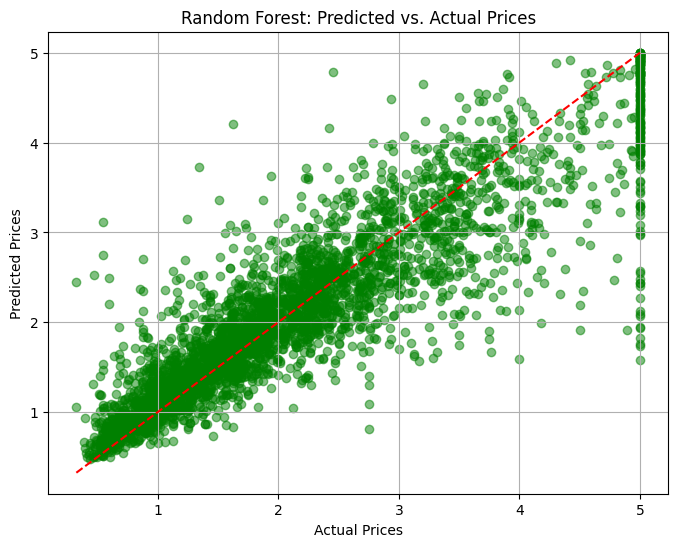

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Create and train the model (no need to scale for trees)
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 2. Predict on test set
y_pred_rf = rf_model.predict(X_test)

# 3. Evaluate
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae:.3f}")
print(f"Random Forest MSE: {mse:.3f}")
print(f"Random Forest R² Score: {r2:.3f}")

# 4. Plot predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest: Predicted vs. Actual Prices")
plt.grid(True)
plt.show()


In [48]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Create and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(
     n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    min_samples_leaf=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predict on test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate
print("R² (Gradient Boosting):", r2_score(y_test, y_pred_gb))


R² (Gradient Boosting): 0.8368571869430879
